#  Iterate Destination Hosts and associated Ports, over time periods, to create multiple Analytical Data Sets &nbsp;&nbsp; (in Big Query)

In [3]:
# use print only as a function
from __future__ import print_function
import sys
sys.version

'2.7.9 (default, Jun 29 2016, 13:08:31) \n[GCC 4.9.2]'

## Connect to data and read into dataframe

In [4]:
__author__ = 'swe03'

import numpy as np
import pandas as pd
import pandas.io.gbq as pdg
import matplotlib.pylab as plt
import matplotlib.pyplot as pplt
from decimal import *
import re 

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

from scipy import stats

from datetime import datetime, timedelta

desired_width = 250
pd.set_option('display.width',desired_width)
pd.set_option('display.max_rows', 500)

###### Install the SQL package if not already installed 

In [5]:
#!pip install pandasql

In [6]:
from pandasql import PandaSQL 
pdsql = PandaSQL()

##### Use an existing table but change the timestamps to create a contiguous distribution.

In [8]:
def Get_recs_w_date_range(date_s,date_e, addr):
    """Iterate through various date ranges to create the a timeframe sample for later aggregation"""
    global dfx2   # Otherwise, dfx2 is considered Local and will not be global scope of the dataframe created above
    query = """SELECT Timestamp, src_addr, src_port, dst_addr, dst_port,
                 cast(duration_ms as integer) as duration_ms,
                 cast(bytes as integer) as bytes,
                 protocol, flow_direction, tcp_flags 
               FROM ipfix.ipfix                
               WHERE Timestamp BETWEEN timestamp('{}') AND timestamp('{}')
                 AND dst_addr in ({})                  # single quotes unnecessary since the ip's are quoted in string 
               LIMIT 50 """.format(date_s,date_e,addr)
               
    #print('The value of local var date_s is: {}'.format(date_s))
    #print('The value of local var date_e is: {}'.format(date_e))
    print('The value of local var addr is: {}'.format(addr))
    dfx1 = pd.read_gbq(query, project_id="network-sec-analytics")
    dfx2 = dfx2.append(dfx1)                                       # Append onto the dfx2 dataframe
    return           

In [9]:
def Get_recs_w_date_range_lowgrain(date_s,date_e):
    """Iterate through various date ranges to create the a timeframe sample for later aggregation"""
    global dfx2   # Otherwise, dfx2 is considered Local and will not be global scope of the dataframe created above
    query = """SELECT Timestamp, src_addr, src_port, dst_addr, dst_port,
                 cast(duration_ms as integer) as duration_ms,
                 cast(bytes as integer) as bytes,
                 protocol, flow_direction, tcp_flags 
               FROM ipfix.ipfix                
               WHERE Timestamp BETWEEN timestamp('{}') AND timestamp('{}')
                 AND dst_addr in ('165.130.217.229') 
                 AND dst_port in ('443')
                 AND src_addr in ('172.29.236.82')""".format(date_s,date_e)
               
    #print('The value of local var date_s is: {}'.format(date_s))
    #print('The value of local var date_e is: {}'.format(date_e))
    #print('The value of local var addr is: {}'.format(addr))
    dfx1 = pd.read_gbq(query, project_id="network-sec-analytics")
    dfx2 = dfx2.append(dfx1)                                       # Append onto the dfx2 dataframe
    return       

In [10]:
def Write_to_gbq(addr_port_s):
  #model_addr_port = "'" + 'prod.' + addr_port_s + "'"
  model_addr_port = 'prod.' + addr_port_s  
  parm_str = pd.Series([model_addr_port]) 
  print("This is the parm str:",parm_str)
  
  pdg.to_gbq(dfx2, model_addr_port, "network-sec-analytics", verbose=True, reauth=False, 
   if_exists='replace', private_key=None)

  #dfx2.to_gbq(parm_str, "network-sec-analytics", verbose=True, reauth=False, 
   #if_exists='replace', private_key=None)
  return

In [11]:
def Initialize_and_Iterate():
  date_start = pd.to_datetime('2017-02-01 00:00:00')           # '2017-02-01 00:00:00'
  date_end_interval   = pd.to_datetime('2017-02-02 23:59:59')  # '2017-02-01 10:59:59'
  
  while date_start <= pd.to_datetime(date_end_interval):
    date_end = date_start + timedelta(minutes=59,seconds=59)   # Set the datetime end of the hour interval
    print('For get_recs function date_start=',date_start)
    print('For get_recs function date_end=',date_end)
    
    Get_recs_w_date_range(date_start,date_end,out_str) # Extract the query Limit above within the specified hour  
    
    date_start = date_end + timedelta(seconds=1)           # Add a second to the nn:59:59 end date to start the next # hour on nn:00:00 start time
  
  return      

In [12]:
def Initialize_and_Iterate_lowgrain():
  date_start = pd.to_datetime('2017-02-01 00:00:00')           # '2017-02-01 00:00:00'
  date_end_interval   = pd.to_datetime('2017-02-01 01:00:00')  # '2017-02-01 10:59:59'
  
  while date_start <= pd.to_datetime(date_end_interval):
    date_end = date_start + timedelta(minutes=59,seconds=59)   # Set the datetime end of the hour interval
    print('For get_recs function date_start=',date_start)
    print('For get_recs function date_end=',date_end)
    
    Get_recs_w_date_range_lowgrain(date_start,date_end) # Extract the query Limit above within the specified hour  
    
    date_start = date_end + timedelta(seconds=1)            
                                                            
  return      

In [13]:
def Create_date_hour():
  global dfx2
  dfx2['duration_ms'].fillna(0, inplace=True)
  dfx2['date_hour'] = dfx2.Timestamp.dt.strftime('%Y-%m-%d-%H')  # This works and creates a Series with Date and Hour
  dfx2['date_hour'] = pd.to_datetime(dfx2['date_hour'] )
  dfx2.reset_index(drop=True, inplace=True)
  return 

### Initiate the Process

##### Read the specific Host Segments reference table from BQ

In [14]:
## This function accomplishes both: 1. Creating an enumerated list of Host Segments to be sent to the Get_recs... function and
##                                  2. Parsing the text strings to enable generating the enumerated list
def read_in_host_segments():
  global out
  host_segs = pd.read_gbq("select Host_Range_Start, Host_Range_End from reference.Host_Segments", project_id="network-sec-analytics")
  host_start = host_segs.Host_Range_Start.str.split('.',expand=True).astype(int)  # This creates a DF.  type(host_start)
  host_end = host_segs.Host_Range_End.str.split('.',expand=True).astype(int)  # This creates a DF.  type(host_end)
  host_start2 = host_segs.join(host_start[3])   # Join the host_seg table with just the last component of the address as int
  host_start2 = host_start2.join(host_end[3],rsuffix='E') # Join to get the host range end value
  host_start2.rename(columns={"3":"start","3E":"end"},inplace=True) 
  host_start2.replace(to_replace='\w+$', value=' ', inplace=True, limit=None, regex=True, method='pad', axis=None) # place a blank in the last addr component
  
  temp_list = []
  end_str = ''
  for index, row in host_start2.iterrows(): 
    counter = host_start2['start'][index]  # necessary to include index or will get "truth value of a Series is ambiguous"
    last = host_start2['end'][index]
  while counter <= last:
    end_str = counter.astype(str)   ## counter retains int dtype
    temp_dict = {'host': row.Host_Range_Start.strip() + end_str}
    temp_list.append(temp_dict)
    counter = counter + 1
    
  out = pd.DataFrame(temp_list)   ## Currently, this will overwrite each df and only retain the last record's df

  return


read_in_host_segments()

Requesting query... ok.
Query running...
Query done.
Processed: 98.0 b

Retrieving results...
Got 3 rows.

Total time taken 1.07 s.
Finished at 2017-04-16 17:28:52.


In [15]:
out

,host
0,165.130.217.225
1,165.130.217.226
2,165.130.217.227
3,165.130.217.228
4,165.130.217.229
5,165.130.217.230
6,165.130.217.231
7,165.130.217.232
8,165.130.217.233
9,165.130.217.234


In [16]:
out_array=out['host'].values
#out_array
for i in range(0, len(out_array)):
  if i == 0:
    out_str = "'" + out_array[i] + "'" + ","
  else:
    if i == (len(out_array)-1):
      out_str += "'" + out_array[i] + "'" 
    else:
      out_str += "'" + out_array[i] + "',"

In [17]:
#print(out_str)
#out_str = out_str + ',' + '165.130.1.9'
print(out_str)

'165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'


##### Call the functions

In [18]:
#global i 
#n = 2
#del dfx2
#for i in range(0, n):                # Set n to be the n number of addr/port ads's to create
dfx2 = pd.DataFrame()              # Create the df that will be appended to for each timeframe
Initialize_and_Iterate()           # For each Host/Port, iterate through the timeframes 
Create_date_hour()                 # Create a Day/Hour variable for the final, appended df
  #del dfx2                           # df has been written to BQ so now delete it

For get_recs function date_start= 2017-02-01 00:00:00
For get_recs function date_end= 2017-02-01 00:59:59
The value of local var addr is: '165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'
Requesting query... ok.
Query running...
Query done.
Processed: 70.0 Gb

Retrieving results...
Got 14 rows.

Total time taken 2.34 s.
Finished at 2017-04-16 17:29:05.
For get_recs function date_start= 2017-02-01 01:00:00
For get_recs function date_end= 2017-02-01 01:59:59
The value of local var addr is: '165.130.217.225','165.130.217.226','165.130.217.227','165.130.217.228','165.130.217.229','165.130.217.230','165.130.217.231','165.130.217.232','165.130.217.233','165.130.217.234','165.130.217.235','165.130.217.236','165.130.217.237','165.130.217.238'
Requesting query... ok.
Query running...
Query done.


In [ ]:
#dfx2 = pd.DataFrame()              # Create the df that will be appended to for each timeframe
#Initialize_and_Iterate_lowgrain()           # For each Host/Port, iterate through the timeframes 
#Create_date_hour()                 # Create a Day/Hour variable for the final, appended df

In [19]:
dfx_s=dfx2.sort_values(['date_hour','dst_addr'],ascending=True)
dfx_s

,Timestamp,src_addr,src_port,dst_addr,dst_port,duration_ms,bytes,protocol,flow_direction,tcp_flags,date_hour
7,2017-02-01 00:16:44,165.130.1.9,53,165.130.217.228,15399,0.0,290,udp,None,[........],2017-02-01 00:00:00
5,2017-02-01 00:16:06,172.29.236.82,45588,165.130.217.229,443,7.0,1001,tcp,None,[FS.PA...],2017-02-01 00:00:00
9,2017-02-01 00:23:21,172.29.236.82,36807,165.130.217.229,443,4.0,817,tcp,None,[FS.PA...],2017-02-01 00:00:00
1,2017-02-01 00:33:12,172.29.236.82,28261,165.130.217.230,443,7.0,1001,tcp,None,[FS.PA...],2017-02-01 00:00:00
3,2017-02-01 00:07:30,172.29.237.82,6981,165.130.217.230,443,49.0,3000,tcp,None,[FS.PA...],2017-02-01 00:00:00
4,2017-02-01 00:52:49,172.29.236.82,16346,165.130.217.230,443,7.0,1001,tcp,None,[FS.PA...],2017-02-01 00:00:00
8,2017-02-01 00:43:28,172.29.237.82,36679,165.130.217.230,443,6.0,2002,tcp,None,[FS.PA...],2017-02-01 00:00:00
10,2017-02-01 00:08:15,172.29.237.82,58667,165.130.217.230,443,40658.0,720,tcp,None,[..R.A...],2017-02-01 00:00:00
0,2017-02-01 00:55:36,172.29.237.82,9798,165.130.217.231,443,7.0,2002,tcp,None,[FS.PA...],2017-02-01 00:00:00
6,2017-02-01 00:32:23,172.29.236.82,8978,165.130.217.231,443,13.0,1273,tcp,None,[FS.PA...],2017-02-01 00:00:00


### Create the Behaviorial Metrics (i.e., In-Degree Entropy measures)

In [20]:
host_count = dfx_s.groupby(dfx_s['date_hour']).count()   ## This creates a dataframe
host_count['dst_addr'] = pd.to_numeric(host_count['dst_addr'],downcast='float')   ## another way to conver is below
#host_count['dst_addr']

In [21]:
unq_src_count=dfx_s.groupby(['date_hour','dst_addr']).src_addr.nunique()    ## This creates a Series
unq_src_count

date_hour            dst_addr       
2017-02-01 00:00:00  165.130.217.228    1
                     165.130.217.229    1
                     165.130.217.230    2
                     165.130.217.231    2
                     165.130.217.235    1
2017-02-01 01:00:00  165.130.217.228    1
                     165.130.217.229    2
                     165.130.217.230    2
                     165.130.217.231    2
2017-02-01 02:00:00  165.130.217.229    1
                     165.130.217.230    2
2017-02-01 03:00:00  165.130.217.229    2
                     165.130.217.230    1
                     165.130.217.231    1
2017-02-01 04:00:00  165.130.217.227    1
                     165.130.217.229    1
                     165.130.217.230    1
                     165.130.217.231    2
2017-02-01 05:00:00  165.130.217.228    1
                     165.130.217.229    2
                     165.130.217.230    1
                     165.130.217.231    2
2017-02-01 06:00:00  165.130.217.227   

In [22]:
#type(unq_src_count)

In [23]:
unq_src_count_df = pdsql("""Select * from unq_src_count""", locals())   ## unq_src_count is a Series
#type(unq_src_count_df)                                                    ## test is a Dataframe
unq_src_count_df['src_addr'] = unq_src_count_df.src_addr.astype(float)
unq_src_count_df                                             ## Dataframe has cols:  date_hour, dst_addr, 
                                                                          ## and src_addr (which are the unique counts)

,date_hour,dst_addr,src_addr
0,2017-02-01 00:00:00.000000,165.130.217.228,1.0
1,2017-02-01 00:00:00.000000,165.130.217.229,1.0
2,2017-02-01 00:00:00.000000,165.130.217.230,2.0
3,2017-02-01 00:00:00.000000,165.130.217.231,2.0
4,2017-02-01 00:00:00.000000,165.130.217.235,1.0
5,2017-02-01 01:00:00.000000,165.130.217.228,1.0
6,2017-02-01 01:00:00.000000,165.130.217.229,2.0
7,2017-02-01 01:00:00.000000,165.130.217.230,2.0
8,2017-02-01 01:00:00.000000,165.130.217.231,2.0
9,2017-02-01 02:00:00.000000,165.130.217.229,1.0


In [24]:
calc_ent1 = pdsql("""SELECT s.date_hour, s.dst_addr as dst_addr_s, s.src_addr as unq_src_addr_cnt, 
                            i.dst_addr as total_dst_addr_cnt, (s.src_addr / i.dst_addr) as ent1 
                  from host_count i join unq_src_count_df s
                  on  i.date_hour = s.date_hour 
                  order by s.date_hour""",locals())
#print(calc_ent1)

In [25]:
calc_ent1['ln_ent1'] = np.log(calc_ent1['ent1'])
calc_ent1

,date_hour,dst_addr_s,unq_src_addr_cnt,total_dst_addr_cnt,ent1,ln_ent1
0,2017-02-01 00:00:00.000000,165.130.217.228,1.0,14.0,0.071429,-2.639057
1,2017-02-01 00:00:00.000000,165.130.217.229,1.0,14.0,0.071429,-2.639057
2,2017-02-01 00:00:00.000000,165.130.217.230,2.0,14.0,0.142857,-1.945910
3,2017-02-01 00:00:00.000000,165.130.217.231,2.0,14.0,0.142857,-1.945910
4,2017-02-01 00:00:00.000000,165.130.217.235,1.0,14.0,0.071429,-2.639057
5,2017-02-01 01:00:00.000000,165.130.217.228,1.0,10.0,0.100000,-2.302585
6,2017-02-01 01:00:00.000000,165.130.217.229,2.0,10.0,0.200000,-1.609438
7,2017-02-01 01:00:00.000000,165.130.217.230,2.0,10.0,0.200000,-1.609438
8,2017-02-01 01:00:00.000000,165.130.217.231,2.0,10.0,0.200000,-1.609438
9,2017-02-01 02:00:00.000000,165.130.217.229,1.0,9.0,0.111111,-2.197225


In [26]:
## This is the step where the summation of each entt1(first ratio created above) * log of ent1 is calculated.
## This summation is now reflected in the date_hour group by
calc_ent1['dst_addr_datehour_group'] = calc_ent1['dst_addr_s']    ## Create a new variable for better desc
calc_ent1['dst_addr_datehour_group'] = calc_ent1.date_hour.str.slice(start=0,stop=13,step=None) #substr the dt/hour only
calc_ent2 = pdsql("""SELECT i.dst_addr_datehour_group, i.total_dst_addr_cnt, i.ent1, i.ln_ent1,
                     sum(i.ent1 * i.ln_ent1) as hx_ent, count(dst_addr_s) as unq_dst_host_count,
                     sum(i.unq_src_addr_cnt) as unq_src_dst_addr_cnt
                  from calc_ent1 i
                  group by i.date_hour
                  order by i.date_hour""",locals())

calc_ent2

,dst_addr_datehour_group,total_dst_addr_cnt,ent1,ln_ent1,hx_ent,unq_dst_host_count,unq_src_dst_addr_cnt
0,2017-02-01 00,14.0,0.071429,-2.639057,-1.121487,5,7.0
1,2017-02-01 01,10.0,0.200000,-1.609438,-1.195921,4,7.0
2,2017-02-01 02,9.0,0.222222,-1.504077,-0.578375,2,3.0
3,2017-02-01 03,4.0,0.250000,-1.386294,-1.039721,3,4.0
4,2017-02-01 04,10.0,0.200000,-1.609438,-1.012663,4,5.0
5,2017-02-01 05,12.0,0.166667,-1.791759,-1.011404,4,6.0
6,2017-02-01 06,14.0,0.142857,-1.945910,-1.210970,5,8.0
7,2017-02-01 07,6.0,0.166667,-1.791759,-1.194506,4,4.0
8,2017-02-01 08,9.0,0.222222,-1.504077,-1.002718,3,6.0
9,2017-02-01 09,10.0,0.100000,-2.302585,-0.874034,3,5.0


In [27]:
calc_ent2['In_degree_entropy'] = -(calc_ent2['hx_ent'] / np.log(calc_ent2['unq_dst_host_count']))
calc_ent2

,dst_addr_datehour_group,total_dst_addr_cnt,ent1,ln_ent1,hx_ent,unq_dst_host_count,unq_src_dst_addr_cnt,In_degree_entropy
0,2017-02-01 00,14.0,0.071429,-2.639057,-1.121487,5,7.0,0.696819
1,2017-02-01 01,10.0,0.200000,-1.609438,-1.195921,4,7.0,0.862675
2,2017-02-01 02,9.0,0.222222,-1.504077,-0.578375,2,3.0,0.834419
3,2017-02-01 03,4.0,0.250000,-1.386294,-1.039721,3,4.0,0.946395
4,2017-02-01 04,10.0,0.200000,-1.609438,-1.012663,4,5.0,0.730482
5,2017-02-01 05,12.0,0.166667,-1.791759,-1.011404,4,6.0,0.729574
6,2017-02-01 06,14.0,0.142857,-1.945910,-1.210970,5,8.0,0.752418
7,2017-02-01 07,6.0,0.166667,-1.791759,-1.194506,4,4.0,0.861654
8,2017-02-01 08,9.0,0.222222,-1.504077,-1.002718,3,6.0,0.912713
9,2017-02-01 09,10.0,0.100000,-2.302585,-0.874034,3,5.0,0.795580


In [84]:
##### Write the dataframe to BQ
dfx2.to_gbq('prod.host_group2', "network-sec-analytics", verbose=True, reauth=False, 
   if_exists='replace', private_key=None)




Streaming Insert is 100% Complete




#### Create some visualizations and other stats

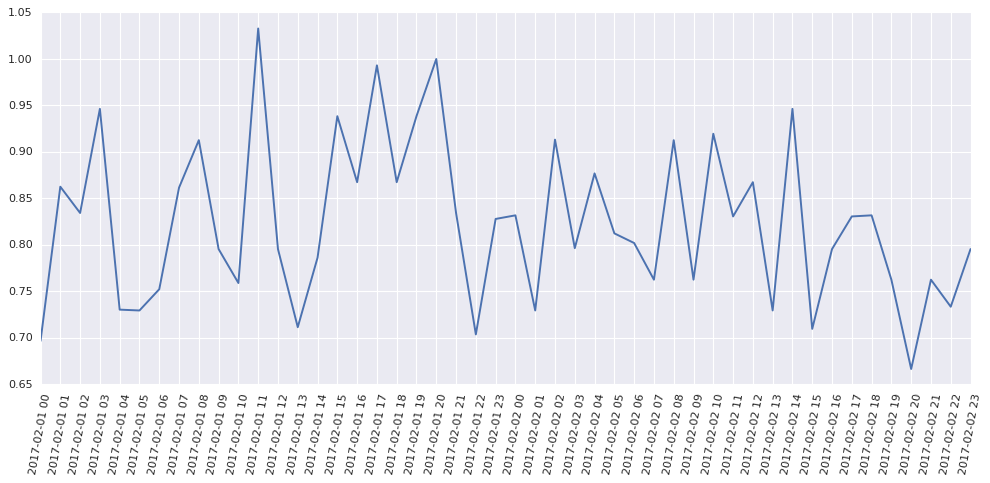

In [28]:
import matplotlib.pyplot as pplt
pplt.plot(calc_ent2['In_degree_entropy'])
pplt.xticks(range(len(calc_ent2['dst_addr_datehour_group'])),calc_ent2['dst_addr_datehour_group'])
pplt.xticks(rotation=80)
pplt.autoscale(enable=True, axis='x', tight=None)
pplt.show()

In [ ]:
def create_unistats(group):
    return {'min': group.min(), 'max': group.max(), 'count': group.count(), 'mean': group.mean()}
  
# These are DataFrames
bytes_dist = dfx2['bytes'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()
bytes_dist = bytes_dist[(bytes_dist['dst_port']==53) ]   # all stats are displayed for just port 53

duration_dist = dfx2['duration_ms'].groupby([dfx2['date_hour'],   
                                  dfx2['dst_port']]).apply(create_unistats).unstack().reset_index()